In [2]:
!pip install MCEq

In [5]:
import matplotlib.pyplot as plt
import numpy as np

#import solver related modules
from MCEq.core import MCEqRun
import mceq_config
#import primary model choices
import crflux.models as pm

In [9]:
mceq_config.e_min = 3.
mceq_config.debug_level = 2
mceq_config.enable_default_tracking = False

In [98]:
mceq_run = MCEqRun(
    #provide the string of the interaction model
    interaction_model='SIBYLL2.3c',
    #primary cosmic ray flux model
    primary_model = (pm.HillasGaisser2012, "H3a"),
    # Zenith angle in degrees. 0=vertical, 90=horizontal
    theta_deg=45.0
)

HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): SIBYLL23C
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_theta_deg(): Zenith angle  45.00
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


## Full access to atmosphere and conversion routines

In [102]:
altitudes = np.linspace(50,0,50) * 1e5 #km->cm
mceq_run.set_density_model(('MSIS00',('SouthPole', 'January')))
depths_south_pole = mceq_run.density_model.h2X(altitudes)
mceq_run.set_density_model(('CORSIKA',('USStd', None)))
depths = mceq_run.density_model.h2X(altitudes)

MCEqRun::set_density_model(): Setting density profile to MSIS00 ('SouthPole', 'January')
MCEqRun::set_theta_deg(): Zenith angle  45.00
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_theta_deg(): Zenith angle  45.00


Text(0.5, 0, 'Altitude in km')

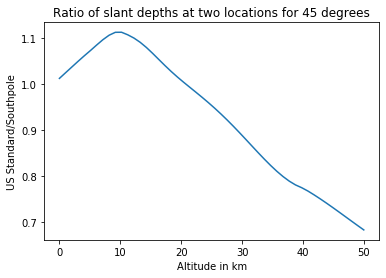

In [104]:
plt.plot(altitudes/1e5, depths/depths_south_pole)
plt.title('Ratio of slant depths at two locations for 45 degrees')
plt.ylabel('US Standard/Southpole')
plt.xlabel('Altitude in km')

## Inclusive flux mode

--> Initial condition for the calculation is the flux of nucleons at the top of the atmosphere

In [105]:
mceq_run.set_primary_model(pm.HillasGaisser2012,'H3a')

MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [106]:
mceq_run.solve(grid_var='X', int_grid=depths)

MCEqRun::solve(): Launching euler solver
MCEqRun::_calculate_integration_path(): X_surface = 1463.60g/cm2
MCEqRun::solve(): for 866 integration steps.
solv_CUDA_sparse(): Performance:   0.03ms/iteration
MCEqRun::solve(): time elapsed during integration:  0.10sec


Text(0.5, 1.0, 'Solid = nucleons, dashed = muons')

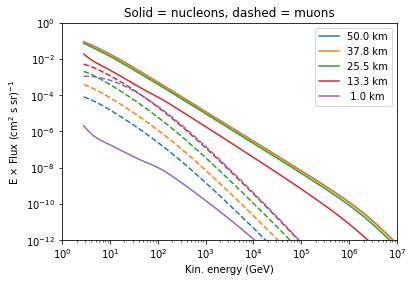

In [107]:
for i, h in enumerate(altitudes):
    if i % 12 != 0:
        continue
    c = plt.loglog(mceq_run.e_grid,
               mceq_run.get_solution('p+', mag=1, grid_idx=i) 
                   + mceq_run.get_solution('n0', mag=1, grid_idx=i), label=f'{h/1e5:4.1f} km')[0].get_color()
    plt.loglog(mceq_run.e_grid,
               mceq_run.get_solution('mu+', mag=1, grid_idx=i) 
               + mceq_run.get_solution('mu-', mag=1, grid_idx=i), c=c, ls='--')
plt.xlim(1,1e7)
plt.ylim(1e-12,1.)
plt.xlabel('Kin. energy (GeV)')
plt.ylabel(r"E $\times$ Flux (cm$^{2}$ s sr)$^{-1}$")
plt.legend()
plt.title('Solid = nucleons, dashed = muons')

## Running in "air shower mode"

--> This simply means that the initial condition is a "delta-function" or single particle spectrum

In [120]:
mceq_run.set_single_primary_particle(1e7, corsika_id=5626) # Iron @ 1e9 GeV

MCEqRun::set_single_primary_particle(): CORSIKA ID 5626, PDG ID None, energy 1e+07 GeV


In [121]:
mceq_run.solve(grid_var='X', int_grid=depths)

MCEqRun::solve(): Launching euler solver
MCEqRun::solve(): for 866 integration steps.
solv_CUDA_sparse(): Performance:   0.03ms/iteration
MCEqRun::solve(): time elapsed during integration:  0.10sec


Text(0.5, 1.0, 'Solid = nucleons, dashed = muons')

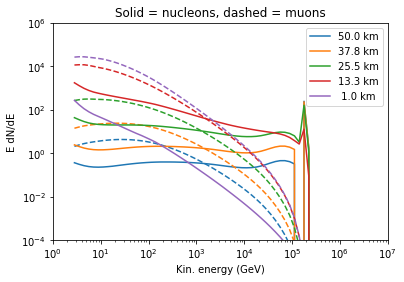

In [122]:
for i, h in enumerate(altitudes):
    if i % 12 != 0:
        continue
    c = plt.loglog(mceq_run.e_grid,
               mceq_run.get_solution('p+', mag=1, grid_idx=i) 
                   + mceq_run.get_solution('n0', mag=1, grid_idx=i), label=f'{h/1e5:4.1f} km')[0].get_color()
    plt.loglog(mceq_run.e_grid,
               mceq_run.get_solution('mu+', mag=1, grid_idx=i) 
               + mceq_run.get_solution('mu-', mag=1, grid_idx=i), c=c, ls='--')
plt.xlim(1,1e7)
plt.ylim(1e-4,1e6)
plt.xlabel('Kin. energy (GeV)')
plt.ylabel(r"E dN/dE")
plt.legend()
plt.title('Solid = nucleons, dashed = muons')